In [86]:
def train_classifier(X, y):
    """Train a classifier using the given training data.
    Trains logistic regression on the input data with default parameters"""

    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    cls = LogisticRegression(random_state=0,  max_iter=10000)
    #clf = LogisticRegression(random_state=0,  max_iter=10000,C = 0.1, solver= 'saga', tol= 0.0001)
    parameters = {'solver' :  [ 'lbfgs', 'liblinear', 'sag', 'saga'],'tol':[0.00001,0.0001], 'C':[0.001, 0.01, 0.1,1]}
    clf = GridSearchCV(cls,parameters,cv=6)
    clf.fit(X, y)
    print(clf.cv_results_)
    return clf
def train_classifier_svc(X, y):
    """Train a classifier using the given training data.
    Trains logistic regression on the input data with default parameters"""

    from sklearn.svm import LinearSVC
    clf = LinearSVC()
    clf.fit(X, y)
    return clf
def train_classifier_semi(X, y,unlabeled,i):
    """Train a classifier using the given training data and part of unlabeled data
    Trains logistic regression on the input data with default parameters"""

    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    import numpy as np
    import scipy.sparse as sp
    from sklearn.svm import LinearSVC
    cls = LogisticRegression(random_state=0,  max_iter=10000)
    parameters = {'solver' :  ['sag', 'saga'],'tol':[0.00001,0.0001], 'C':[0.001, 0.01, 0.1,1]}
    clf = GridSearchCV(cls,parameters,cv=5)
    #clf = LogisticRegression(random_state=0,  max_iter=10000,C = 0.1, solver= 'sag', tol= 0.0001)
    clf.fit(X, y)
    svc = LinearSVC()
    svc.fit(X,y)
    mixX = X
    mixy = list(y)
    #print(clf.cv_results_)
    if i != 0:
        part = int(unlabeled.X.shape[0]/10)*i
        pred = clf.predict(unlabeled.X[:part])
        predsvc = svc.predict(unlabeled.X[:part])
        #preprob = clf.predict_proba(unlabeled.X[:part])
        for j in range(0,part):
            #if preprob[j][0] < 0.2 or preprob[j][0] > 0.8:
            if pred[j] == predsvc[j]:
                mixX = sp.vstack((mixX, unlabeled.X[j]), format='csr')
                mixy.append(pred[j])
    mixy = np.array(mixy)
    return (clf,mixX,mixy)


def evaluate(X, yt, cls, name='data'):
    """Evaluated a classifier on the given labeled data using accuracy."""
    from sklearn import metrics
    yp = cls.predict(X)
    #print("Predict ", cls.predict(X[0]))
    #print("Predict Prob ",cls.predict_proba(X[0]))
    acc = metrics.accuracy_score(yt, yp)
    print("  Accuracy on %s  is: %s" % (name, acc))
    return acc


In [56]:
#!/bin/python

def read_files(tarfname,m,n):
    """Read the training and development data from the sentiment tar file.
    The returned object contains various fields that store sentiment data, such as:

    train_data,dev_data: array of documents (array of words)
    train_fnames,dev_fnames: list of filenames of the doccuments (same length as data)
    train_labels,dev_labels: the true string label for each document (same length as data)

    The data is also preprocessed for use with scikit-learn, as:

    count_vec: CountVectorizer used to process the data (for reapplication on new data)
    trainX,devX: array of vectors representing Bags of Words, i.e. documents processed through the vectorizer
    le: LabelEncoder, i.e. a mapper from string labels to ints (stored for reapplication)
    target_labels: List of labels (same order as used in le)
    trainy,devy: array of int labels, one for each document
    """
    import tarfile
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    tar = tarfile.open(tarfname, "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name
            
            
    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    #from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    sentiment.tf_vect = TfidfVectorizer(min_df=m, max_df=n)
    #sentiment.count_vect = CountVectorizer()
    #sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.trainX = sentiment.tf_vect.fit_transform(sentiment.train_data)
    #sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    sentiment.devX = sentiment.tf_vect.transform(sentiment.dev_data)
    from sklearn import preprocessing
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    tar.close()
    return sentiment

def read_unlabeled(tarfname, sentiment):
    """Reads the unlabeled data.

    The returned object contains three fields that represent the unlabeled data.

    data: documents, represented as sequence of words
    fnames: list of filenames, one for each document
    X: bag of word vector for each document, using the sentiment.vectorizer
    """
    import tarfile
    import nltk
    nltk.download('punkt')
    #from nltk.corpus import stopwords
    #stop = stopwords.words('english')
    tar = tarfile.open(tarfname, "r:gz")
    class Data: pass
    unlabeled = Data()
    unlabeled.data = []
    
    unlabeledname = "unlabeled.tsv"
    for member in tar.getmembers():
        if 'unlabeled.tsv' in member.name:
            unlabeledname = member.name
            
    print(unlabeledname)
    tf = tar.extractfile(unlabeledname)
    for line in tf:
        line = line.decode("utf-8")
        text = line.strip()
        unlabeled.data.append(text)
        unlabeled.data.append(' '.join([word.lower() for word in nltk.word_tokenize(text) 
                      if word.isalpha()]))
        
            
    #unlabeled.X = sentiment.count_vect.transform(unlabeled.data)
    unlabeled.X = sentiment.tf_vect.transform(unlabeled.data)
    print(unlabeled.X.shape)
    tar.close()
    return unlabeled

def read_tsv(tar, fname):
    import nltk
    nltk.download('punkt')
    #from nltk.corpus import stopwords
    #stop = stopwords.words('english')
    member = tar.getmember(fname)
    print(member.name)
    tf = tar.extractfile(member)
    data = []
    labels = []
    for line in tf:
        line = line.decode("utf-8")
        (label,text) = line.strip().split("\t")
        labels.append(label)
        #data.append(text)
        data.append(' '.join([word.lower() for word in nltk.word_tokenize(text) 
                      if  word.isalpha()]))
    return data, labels

def write_pred_kaggle_file(unlabeled, cls, outfname, sentiment):
    """Writes the predictions in Kaggle format.

    Given the unlabeled object, classifier, outputfilename, and the sentiment object,
    this function write sthe predictions of the classifier on the unlabeled data and
    writes it to the outputfilename. The sentiment object is required to ensure
    consistent label names.
    """
    yp = cls.predict(unlabeled.X)
    labels = sentiment.le.inverse_transform(yp)
    f = open(outfname, 'w')
    f.write("ID,LABEL\n")
    for i in range(len(unlabeled.data)):
        f.write(str(i+1))
        f.write(",")
        f.write(labels[i])
        f.write("\n")
    f.close()


def write_gold_kaggle_file(tsvfile, outfname):
    """Writes the output Kaggle file of the truth.

    You will not be able to run this code, since the tsvfile is not
    accessible to you (it is the test labels).
    """
    f = open(outfname, 'w')
    f.write("ID,LABEL\n")
    i = 0
    with open(tsvfile, 'r') as tf:
        for line in tf:
            (label,review) = line.strip().split("\t")
            i += 1
            f.write(str(i))
            f.write(",")
            f.write(label)
            f.write("\n")
    f.close()

def write_basic_kaggle_file(tsvfile, outfname):
    """Writes the output Kaggle file of the naive baseline.

    This baseline predicts POSITIVE for all the instances.
    """
    f = open(outfname, 'w')
    f.write("ID,LABEL\n")
    i = 0
    with open(tsvfile, 'r') as tf:
        for line in tf:
            (label,review) = line.strip().split("\t")
            i += 1
            f.write(str(i))
            f.write(",")
            f.write("POSITIVE")
            f.write("\n")
    f.close()

Supervised

In [75]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
cls = []
traina = []
deva = []

sentiment = read_files(tarfname,1,0.5)
print("\nTraining classifier")
clf = train_classifier(sentiment.trainX, sentiment.trainy)
print("\nEvaluating")
cls.append(clf)
traina.append(evaluate(sentiment.trainX, sentiment.trainy, clf, 'train'))
deva.append(evaluate(sentiment.devX, sentiment.devy, clf, 'dev'))

print("train acc",traina)
print("dev acc",deva)
#print("\nReading unlabeled data")
#unlabeled = read_unlabeled(tarfname, sentiment)
#print("Writing predictions to a file")
#write_pred_kaggle_file(unlabeled, cls[3], "data/sentiment-pred.csv", sentiment)
#write_basic_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-basic.csv")

# You can't run this since you do not have the true labels
# print "Writing gold file"
# write_gold_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-gold.csv")


Reading data
-- train data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/train.tsv
4582
-- dev data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/dev.tsv
458
-- transforming data and labels

Training classifier

Evaluating
  Accuracy on train  is: 0.9855958096900916
  Accuracy on dev  is: 0.7838427947598253
train acc [0.9855958096900916]
dev acc [0.7838427947598253]


find decisive features

In [30]:
import numpy as np
coefficients=clf.coef_[0]
k = 50
top_k =np.argsort(coefficients)[-k:]
top_k_words = []

print('-'*50)
print('Top k=%d' %k)
print('-'*50)
for i in top_k:
    top_k_words.append(sentiment.count_vect.get_feature_names()[i])
print(top_k_words)
print('-'*50)
print('Bottom k=%d' %k)
print('-'*50)
#top_k = np.argpartition(coefficients, -k)[-k:]
bottom_k =np.argsort(coefficients)[:k]
bottom_k_words = []
#print(top_k)
for i in bottom_k:
    #print(sentiment.count_vect.get_feature_names()[i])
    bottom_k_words.append(sentiment.count_vect.get_feature_names()[i])
print(bottom_k_words)

--------------------------------------------------
Top k=50
--------------------------------------------------
['find', 'tacos', 'spicy', 'know', 'hidden', 'hands', 'yes', 'recommend', 'right', 'authentic', 'quick', 'attentive', 'enjoyed', 'vegas', 'menu', 'house', 'fast', 'city', 'always', 'quickly', 'yum', 'thai', 'can', 'surprised', 'montreal', 'fun', 'professional', 'style', 'pleased', 'definitely', 'tasty', 'easy', 'happy', 'wine', 'loved', 'town', 'little', 'fantastic', 'wonderful', 'spot', 'perfect', 'friendly', 'favorite', 'love', 'awesome', 'best', 'great', 'excellent', 'delicious', 'amazing']
--------------------------------------------------
Bottom k=50
--------------------------------------------------
['worst', 'horrible', 'terrible', 'rude', 'not', 'disappointing', 'disappointed', 'slow', 'average', 'asked', 'star', 'bad', 'awful', 'overpriced', 'excited', 'ok', 'went', 'dirty', 'bland', 'poor', 'seems', 'nothing', 'tasted', 'rather', 'should', 'meh', 'waitress', 'expensi

Check whether the words above is stop word

In [48]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
'rather' in stop

False

Semi Supervised for portion of unlabeled from 0 to 100%

In [153]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = read_files(tarfname,1,0.5)
print("\nReading unlabeled data")
unlabeled = read_unlabeled(tarfname, sentiment)
clss = [0]*12
i = 0
mixtrainX = sentiment.trainX
mixtrainY = sentiment.trainy
trainacc = []
devacc = []
for i in range(0,11):
    print("\nTraining classifier with ",10*i,"% unlabelled data")
    (cls[i],mixtrainX,mixtrainY) = train_classifier_semi(mixtrainX, mixtrainY,unlabeled,i)
    print("\nEvaluating")
    trainacc.append(evaluate(sentiment.trainX, sentiment.trainy, clss[i], 'train'))
    devacc.append(evaluate(sentiment.devX, sentiment.devy, clss[i], 'dev'))

print("Training accuracy array ",trainacc)
print("Dev accuracy array ",devacc)
print("Writing predictions to a file")
write_pred_kaggle_file(unlabeled, clss[10], "data/sentiment-pred.csv", sentiment)
#write_basic_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-basic.csv")

# You can't run this since you do not have the true labels
# print "Writing gold file"
# write_gold_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-gold.csv")


Reading data
-- train data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/train.tsv
4582
-- dev data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/dev.tsv
458
-- transforming data and labels

Reading unlabeled data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/unlabeled.tsv
(91524, 4627)

Training classifier with  0 % unlabelled data
{'mean_fit_time': array([0.00710932, 0.00545589, 0.00363692, 0.003637  , 0.08398914,
       0.06234566, 0.12428228, 0.03786874, 0.0079143 , 0.00694434,
       0.00578229, 0.00363684, 0.03157846, 0.0243036 , 0.03510245,
       0.02794091, 0.00826661, 0.00843191, 0.00512489, 0.00413132,
       0.02314599, 0.01735997, 

{'mean_fit_time': array([0.00694386, 0.00760547, 0.0038023 , 0.00363739, 0.08713023,
       0.06414882, 0.12730606, 0.03885285, 0.00677903, 0.00727487,
       0.00429837, 0.00396776, 0.03306627, 0.02449401, 0.03438687,
       0.02793829, 0.0084122 , 0.00843231, 0.00512552, 0.00429885,
       0.02364246, 0.01735973, 0.03341993, 0.02595647, 0.01998146,
       0.0201718 , 0.00726104, 0.00728567, 0.02908874, 0.02612289,
       0.03804994, 0.02545921]), 'std_fit_time': array([0.00107155, 0.00116893, 0.000234  , 0.00023377, 0.00999665,
       0.00023389, 0.0558266 , 0.0016367 , 0.00084292, 0.00123751,
       0.00084303, 0.00070166, 0.00451589, 0.00343201, 0.00142295,
       0.00046946, 0.00040583, 0.00040471, 0.00023383, 0.00023394,
       0.00093527, 0.00039078, 0.00375014, 0.00061883, 0.00061921,
       0.0006513 , 0.0004779 , 0.00094306, 0.00124786, 0.0043303 ,
       0.006065  , 0.00084405]), 'mean_score_time': array([0.00049615, 0.00033085, 0.00016538, 0.00016538, 0.00066169,
       0.0

{'mean_fit_time': array([0.00644779, 0.00661333, 0.00396752, 0.00347145, 0.08401346,
       0.05340044, 0.04960243, 0.0379777 , 0.0069445 , 0.00694442,
       0.00446407, 0.00413354, 0.02975957, 0.02430431, 0.03522865,
       0.02942952, 0.01089644, 0.00992997, 0.00558861, 0.0051252 ,
       0.02431695, 0.01967446, 0.03522015, 0.02613878, 0.01898805,
       0.02149336, 0.00827726, 0.00676203, 0.03192957, 0.02924061,
       0.03868747, 0.02975957]), 'std_fit_time': array([4.05104014e-04, 2.33943127e-04, 1.94667955e-07, 1.12391596e-07,
       9.70307457e-03, 3.76021392e-03, 2.10745496e-03, 3.41418662e-03,
       2.97360213e-07, 3.89335909e-07, 4.05006684e-04, 2.33943127e-04,
       2.65533143e-03, 1.45984050e-03, 1.85937971e-03, 4.66204405e-04,
       1.98155635e-03, 7.09093419e-04, 2.34598821e-04, 2.33886992e-04,
       2.09531325e-03, 1.16904119e-03, 1.79001603e-03, 1.57732807e-03,
       1.85668986e-03, 3.49210064e-03, 2.40615997e-04, 6.01080553e-04,
       2.47160888e-03, 4.19218917e


Evaluating
  Accuracy on train  is: 0.8910955914447839
  Accuracy on dev  is: 0.7663755458515283

Training classifier with  30 % unlabelled data
{'mean_fit_time': array([0.00826693, 0.00876307, 0.00429837, 0.00446367, 0.09872834,
       0.06267214, 0.06429259, 0.04777575, 0.01105523, 0.00925859,
       0.007605  , 0.00529019, 0.03670422, 0.03273598, 0.04516061,
       0.04012887, 0.03239067, 0.02051131, 0.00858355, 0.0069325 ,
       0.02927176, 0.02599891, 0.04445275, 0.03405563, 0.02879222,
       0.02560321, 0.01025089, 0.01058118, 0.04380957, 0.03487976,
       0.04727316, 0.03670438]), 'std_fit_time': array([1.23674237e-03, 1.63710402e-03, 2.33774520e-04, 0.00000000e+00,
       1.08992301e-02, 4.99123496e-03, 7.13809278e-03, 3.51554898e-03,
       1.41251148e-03, 2.33886992e-04, 1.42229052e-03, 2.33774520e-04,
       1.43582650e-03, 3.86297671e-03, 1.46928204e-03, 5.72360181e-03,
       1.63789227e-02, 2.45320048e-03, 1.70096865e-03, 2.09817380e-05,
       8.10486986e-04, 2.10036


Evaluating
  Accuracy on train  is: 0.8860759493670886
  Accuracy on dev  is: 0.7663755458515283

Training classifier with  40 % unlabelled data
{'mean_fit_time': array([0.01289614, 0.01125097, 0.00858529, 0.00644787, 0.10234094,
       0.07158891, 0.10300207, 0.06943965, 0.0147148 , 0.01421913,
       0.00925827, 0.00892742, 0.05274113, 0.03719942, 0.06745561,
       0.05472493, 0.0315787 , 0.03224007, 0.0135572 , 0.01398532,
       0.05968523, 0.03655942, 0.06215636, 0.04744697, 0.0464325 ,
       0.04546245, 0.01736299, 0.01554116, 0.07076104, 0.05356749,
       0.09324749, 0.05606699]), 'std_fit_time': array([1.07158374e-03, 6.20670955e-04, 1.33818464e-03, 4.05006684e-04,
       4.47937609e-03, 4.69388651e-03, 7.93926620e-03, 4.56411575e-03,
       2.23046738e-03, 2.57191309e-03, 2.33830736e-04, 1.12391596e-07,
       3.76248584e-03, 2.92043672e-03, 6.69157295e-03, 2.60346530e-03,
       3.62999268e-03, 3.16340269e-03, 1.23757074e-03, 9.36528094e-04,
       1.24457441e-02, 2.32886


Evaluating
  Accuracy on train  is: 0.8786556089044085
  Accuracy on dev  is: 0.7620087336244541

Training classifier with  50 % unlabelled data
{'mean_fit_time': array([0.01454965, 0.01653345, 0.01917887, 0.01322651, 0.13110987,
       0.07562558, 0.11693939, 0.08980934, 0.02547455, 0.02596935,
       0.0195508 , 0.01521071, 0.08566022, 0.0541238 , 0.09197442,
       0.08207051, 0.04860822, 0.05026134, 0.03042142, 0.02248557,
       0.08403095, 0.05511793, 0.09690754, 0.07820217, 0.08316278,
       0.07208538, 0.03670406, 0.03009081, 0.10352008, 0.0685122 ,
       0.09972906, 0.10184526]), 'std_fit_time': array([0.00046777, 0.00142258, 0.00163648, 0.00084309, 0.01018408,
       0.0058996 , 0.00608248, 0.00400072, 0.00335482, 0.00365335,
       0.00301468, 0.00130189, 0.00685894, 0.00321498, 0.00341009,
       0.00236648, 0.00612841, 0.00467667, 0.0026348 , 0.00101954,
       0.01377667, 0.00651259, 0.00434349, 0.00472888, 0.00382738,
       0.01454753, 0.00477508, 0.00376292, 0.01021


Evaluating
  Accuracy on train  is: 0.872326494980358
  Accuracy on dev  is: 0.7620087336244541

Training classifier with  60 % unlabelled data
{'mean_fit_time': array([0.02066676, 0.02331241, 0.02579204, 0.02612265, 0.18219733,
       0.13309304, 0.19013341, 0.15375988, 0.02663279, 0.03207477,
       0.02744587, 0.02349369, 0.10833947, 0.0838747 , 0.17910409,
       0.13264958, 0.07340789, 0.08696556, 0.04976575, 0.04017568,
       0.12371023, 0.09919922, 0.15844568, 0.12451871, 0.11308797,
       0.11308837, 0.06563743, 0.05538718, 0.16483704, 0.11292251,
       0.17095423, 0.13609632]), 'std_fit_time': array([0.00153345, 0.00743444, 0.00140237, 0.00061887, 0.02887156,
       0.00851738, 0.00199757, 0.00943704, 0.00103591, 0.00329869,
       0.00130209, 0.00129394, 0.0052109 , 0.00353207, 0.00913471,
       0.00580873, 0.010076  , 0.00622543, 0.0014226 , 0.00386312,
       0.01223533, 0.00919768, 0.0248563 , 0.00110062, 0.03354621,
       0.02600433, 0.0049489 , 0.00627821, 0.019767


Evaluating
  Accuracy on train  is: 0.8662156263640332
  Accuracy on dev  is: 0.7685589519650655

Training classifier with  70 % unlabelled data
{'mean_fit_time': array([0.0322543 , 0.03769636, 0.05141822, 0.05075701, 0.22756584,
       0.15992967, 0.27819022, 0.21763055, 0.04893851, 0.05241084,
       0.06744679, 0.06088146, 0.18255417, 0.12916223, 0.24063333,
       0.20076831, 0.09571576, 0.10053595, 0.09540995, 0.07721949,
       0.18224072, 0.15382838, 0.23611776, 0.20838904, 0.11622922,
       0.11689083, 0.11940161, 0.11160064, 0.22508351, 0.18855151,
       0.22938609, 0.19544951]), 'std_fit_time': array([0.00439969, 0.0039055 , 0.00609247, 0.00367475, 0.0084252 ,
       0.0013166 , 0.01581394, 0.00471361, 0.00362995, 0.0044611 ,
       0.00108622, 0.00132731, 0.01476684, 0.00081051, 0.00398387,
       0.00155475, 0.0168218 , 0.00994744, 0.00302697, 0.00516908,
       0.00413399, 0.00121629, 0.00496276, 0.00070218, 0.03023144,
       0.02779448, 0.00872927, 0.00948915, 0.01377


Evaluating
  Accuracy on train  is: 0.8592317765168049
  Accuracy on dev  is: 0.7729257641921398

Training classifier with  80 % unlabelled data
{'mean_fit_time': array([0.04662426, 0.05373367, 0.10862454, 0.09837294, 0.39580814,
       0.3096954 , 0.53518422, 0.4084367 , 0.1048216 , 0.11294111,
       0.13821872, 0.12052703, 0.30404782, 0.26800537, 0.46309861,
       0.4077119 , 0.15113695, 0.16732955, 0.18021313, 0.16301862,
       0.32873138, 0.27601639, 0.43388367, 0.33815535, 0.15161117,
       0.15971231, 0.25163778, 0.22154633, 0.41349856, 0.32488004,
       0.43449593, 0.36210338]), 'std_fit_time': array([0.00107133, 0.00306662, 0.00398895, 0.00708865, 0.02906015,
       0.02519061, 0.02066627, 0.0093877 , 0.00436798, 0.00415121,
       0.00182579, 0.00491059, 0.01528774, 0.01870528, 0.02118839,
       0.02315121, 0.02451501, 0.03377047, 0.0053931 , 0.00866034,
       0.00430411, 0.02267911, 0.02435953, 0.02522492, 0.02855211,
       0.04105269, 0.0270235 , 0.00314628, 0.02512


Evaluating
  Accuracy on train  is: 0.8522479266695766
  Accuracy on dev  is: 0.7729257641921398

Training classifier with  90 % unlabelled data
{'mean_fit_time': array([0.07704544, 0.08316271, 0.17922107, 0.16715201, 0.60499819,
       0.42573357, 0.84472537, 0.66386565, 0.15706674, 0.18021409,
       0.24254433, 0.18681574, 0.50284553, 0.40325006, 0.71414193,
       0.60814269, 0.19955762, 0.2142721 , 0.32903067, 0.30652777,
       0.54230793, 0.39488411, 0.69276921, 0.61274616, 0.24536769,
       0.25594783, 0.45003692, 0.37299236, 0.69260947, 0.53038971,
       0.75890088, 0.60363213]), 'std_fit_time': array([0.00734954, 0.00619955, 0.00534607, 0.01827849, 0.05473722,
       0.00673175, 0.06619078, 0.03112384, 0.0060095 , 0.01095979,
       0.00772727, 0.00395944, 0.01086523, 0.00882815, 0.00939211,
       0.01462143, 0.01003764, 0.00750031, 0.0113977 , 0.01872254,
       0.04453759, 0.00390405, 0.03019225, 0.03235885, 0.03329192,
       0.02173876, 0.00528465, 0.00438033, 0.00853


Evaluating
  Accuracy on train  is: 0.8485377564382366
  Accuracy on dev  is: 0.7620087336244541

Training classifier with  100 % unlabelled data
{'mean_fit_time': array([0.11571113, 0.11887455, 0.30388268, 0.24700824, 0.70619504,
       0.62996801, 1.25141692, 0.93037391, 0.24401697, 0.26005371,
       0.31310542, 0.29664278, 0.6684552 , 0.61423405, 1.06673074,
       0.86124635, 0.35844326, 0.38821348, 0.46837306, 0.39975874,
       0.74023787, 0.61985668, 1.05568663, 0.80174518, 0.51468261,
       0.58410613, 0.57436156, 0.47599395, 0.93880765, 0.8190705 ,
       1.04079906, 0.78918187]), 'std_fit_time': array([0.0168836 , 0.0155656 , 0.00520709, 0.01052972, 0.04801103,
       0.04487226, 0.04212921, 0.07404626, 0.04842811, 0.04336386,
       0.00338437, 0.03160618, 0.04910586, 0.04582581, 0.00161802,
       0.04090714, 0.11572705, 0.12109743, 0.00369419, 0.00225217,
       0.02029599, 0.03929555, 0.04597028, 0.00118297, 0.21066107,
       0.19638132, 0.01763356, 0.01547597, 0.0286


Evaluating
  Accuracy on train  is: 0.8424268878219118
  Accuracy on dev  is: 0.7685589519650655
Training accuracy array  [0.8950240069838499, 0.8950240069838499, 0.8910955914447839, 0.8860759493670886, 0.8786556089044085, 0.872326494980358, 0.8662156263640332, 0.8592317765168049, 0.8522479266695766, 0.8485377564382366, 0.8424268878219118]
Dev accuracy array  [0.7707423580786026, 0.7707423580786026, 0.7663755458515283, 0.7663755458515283, 0.7620087336244541, 0.7620087336244541, 0.7685589519650655, 0.7729257641921398, 0.7729257641921398, 0.7620087336244541, 0.7685589519650655]
Writing predictions to a file


C:\Users\xinme\Anaconda2\envs\py3.6\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Semisupervised for portion 30% with stoping strategy depending on dev accuracy change

In [ ]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = read_files(tarfname,1,0.5)
print("\nReading unlabeled data")
unlabeled = read_unlabeled(tarfname, sentiment)
cls = []
i = 0
mixtrainX = sentiment.trainX
mixtrainY = sentiment.trainy
trainacc = []
devacc = []
impro = 1
while impro > 0.002 or impro < -0.001:
    (clf,mixtrainX,mixtrainY) = train_classifier_semi(mixtrainX, mixtrainY,unlabeled,3)
    print("\nEvaluating")
    cls.append(clf)
    trainacc.append(evaluate(sentiment.trainX, sentiment.trainy, clf, 'train'))
    devacc.append(evaluate(sentiment.devX, sentiment.devy, clf, 'dev'))
    if impro == 1:
        impro = 0.9
    else:
        impro = devacc[len(devacc)-1]-devacc[len(devacc)-2]

print("Training accuracy array ",trainacc)
print("Dev accuracy array ",devacc)
print("Writing predictions to a file")
last = len(cls)-1
write_pred_kaggle_file(unlabeled, cls[last], "data/sentiment-pred.csv", sentiment)
#write_basic_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-basic.csv")

# You can't run this since you do not have the true labels
# print "Writing gold file"
# write_gold_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-gold.csv")

Reading data
-- train data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/train.tsv
4582
-- dev data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/dev.tsv
458
-- transforming data and labels

Reading unlabeled data
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
sentiment/unlabeled.tsv
(183048, 9425)

Evaluating
  Accuracy on train  is: 0.8967699694456569
  Accuracy on dev  is: 0.7707423580786026

Evaluating
  Accuracy on train  is: 0.8780008729812309
  Accuracy on dev  is: 0.7663755458515283

Evaluating
  Accuracy on train  is: 0.8738542121344391
  Accuracy on dev  is: 0.7685589519650655

Evaluating
  Accuracy on train  is: 0.8731994762112615
  Accuracy on

semi supervised of fixed interation

In [164]:
cls = []
i = 0
mixtrainX = sentiment.trainX
mixtrainY = sentiment.trainy
trainacc = []
devacc = []
k = int(sentiment.devX.shape[0]/100)
for i in range(0,k):
    (clf,mixtrainX,mixtrainY) = train_classifier_semi(mixtrainX, mixtrainY,unlabeled,)
    print("\nEvaluating")
    cls.append(clf)
    trainacc.append(evaluate(sentiment.trainX, sentiment.trainy, clf, 'train'))
    devacc.append(evaluate(sentiment.devX, sentiment.devy, clf, 'dev'))
    if impro == 1:
        impro = 0.9
    else:
        impro = devacc[len(devacc)-1]-devacc[len(devacc)-2]

print("Training accuracy array ",trainacc)
print("Dev accuracy array ",devacc)
print("Writing predictions to a file")
last = len(cls)-1
write_pred_kaggle_file(unlabeled, cls[last], "data/sentiment-pred.csv", sentiment)
#write_basic_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-basic.csv")

# You can't run this since you do not have the true labels
# print "Writing gold file"
# write_gold_kaggle_file("data/sentiment-unlabeled.tsv", "data/sentiment-gold.csv")

{'mean_fit_time': array([0.008111  , 0.00659585, 0.00363731, 0.00347201, 0.0812041 ,
       0.0608693 , 0.12154849, 0.03635168, 0.00956313, 0.00677872,
       0.00479436, 0.00413338, 0.03587731, 0.02777529, 0.03687819,
       0.02759767, 0.01022577, 0.00925628, 0.00512544, 0.00479476,
       0.0226268 , 0.02000618, 0.03704548, 0.03193259, 0.02794131,
       0.02579228, 0.00777046, 0.0071102 , 0.04098956, 0.02992535,
       0.03719989, 0.02744452]), 'std_fit_time': array([0.00162828, 0.00045004, 0.00023383, 0.00040481, 0.00963949,
       0.00050065, 0.05292587, 0.00095333, 0.00127221, 0.00046732,
       0.00084271, 0.00061868, 0.00436837, 0.00265535, 0.00084384,
       0.00101431, 0.0019382 , 0.00125334, 0.00023338, 0.00084223,
       0.00321741, 0.00240511, 0.00379477, 0.0037446 , 0.00023512,
       0.0024637 , 0.00061928, 0.000621  , 0.00749125, 0.00670751,
       0.00780024, 0.00084713]), 'mean_score_time': array([0.00048749, 0.00049257, 0.00049607, 0.00049599, 0.00066153,
       0.0


Evaluating
  Accuracy on train  is: 0.8950240069838499
  Accuracy on dev  is: 0.7707423580786026
{'mean_fit_time': array([0.01091202, 0.01041547, 0.00925859, 0.00727431, 0.11407948,
       0.07258097, 0.0983727 , 0.07803671, 0.01504469, 0.0153869 ,
       0.0120724 , 0.0117387 , 0.0540638 , 0.03505079, 0.06525016,
       0.06299146, 0.02678386, 0.02546199, 0.01256506, 0.01107685,
       0.04728468, 0.03223952, 0.05954512, 0.05122232, 0.02973366,
       0.03058656, 0.0166986 , 0.01471464, 0.05522108, 0.04483207,
       0.06232945, 0.05042569]), 'std_fit_time': array([0.0004053 , 0.0004053 , 0.00153318, 0.00023361, 0.00571296,
       0.00503112, 0.00269658, 0.00353833, 0.00446038, 0.00201152,
       0.00247882, 0.00130103, 0.00185489, 0.00203765, 0.00384613,
       0.0053574 , 0.00121521, 0.00409774, 0.00046761, 0.00023389,
       0.0042148 , 0.0038626 , 0.00571666, 0.00388241, 0.00279818,
       0.00223063, 0.00061898, 0.00023394, 0.00685279, 0.00450248,
       0.0066826 , 0.00325013])


Evaluating
  Accuracy on train  is: 0.8773461370580532
  Accuracy on dev  is: 0.7751091703056768
{'mean_fit_time': array([0.01950892, 0.02132765, 0.02165874, 0.01619848, 0.15000812,
       0.08919207, 0.14837742, 0.14580035, 0.02992495, 0.02496505,
       0.01967462, 0.0166986 , 0.0970788 , 0.06388354, 0.12803547,
       0.10770122, 0.05143229, 0.05555153, 0.02860236, 0.02479974,
       0.09492326, 0.07264717, 0.12175099, 0.09529757, 0.06166919,
       0.06479653, 0.0440011 , 0.04414813, 0.16797876, 0.11986613,
       0.1557436 , 0.12499197]), 'std_fit_time': array([0.00275616, 0.00225495, 0.00237328, 0.0030941 , 0.0272039 ,
       0.00409806, 0.00632374, 0.00424216, 0.00688814, 0.00630517,
       0.00023406, 0.00023366, 0.00310792, 0.0031443 , 0.00265305,
       0.00429115, 0.0073482 , 0.00788402, 0.00116899, 0.00040491,
       0.0016068 , 0.00734815, 0.00298417, 0.00450977, 0.01403136,
       0.01928118, 0.00626733, 0.003302  , 0.01771064, 0.00199777,
       0.01096474, 0.00876096])


Evaluating
  Accuracy on train  is: 0.8614142295940638
  Accuracy on dev  is: 0.7685589519650655
{'mean_fit_time': array([0.02612289, 0.02694972, 0.04298639, 0.04069193, 0.21394149,
       0.15590922, 0.25329375, 0.19558899, 0.03885357, 0.04001133,
       0.04215988, 0.04249072, 0.14565825, 0.12003183, 0.21939715,
       0.17905577, 0.07125902, 0.07291214, 0.06464529, 0.0623223 ,
       0.20137628, 0.14995718, 0.25577013, 0.16814383, 0.09027227,
       0.0906028 , 0.09374412, 0.08927973, 0.20980763, 0.15284061,
       0.21118927, 0.17813381]), 'std_fit_time': array([2.33886992e-04, 2.33943289e-04, 7.85627423e-03, 3.73349144e-03,
       9.63770056e-03, 1.30168220e-03, 1.53158783e-03, 5.03129092e-03,
       9.35379063e-04, 1.16937840e-03, 2.97360213e-07, 1.16898499e-03,
       1.08393443e-02, 1.21492271e-03, 1.00867432e-02, 5.44827947e-03,
       1.63671867e-03, 2.25505169e-03, 3.03956588e-03, 1.24621633e-03,
       6.74055516e-03, 5.15986562e-03, 3.37238576e-03, 4.20867191e-03,
       


Evaluating
  Accuracy on train  is: 0.8522479266695766
  Accuracy on dev  is: 0.7707423580786026
{'mean_fit_time': array([0.03605485, 0.04001085, 0.08167458, 0.06795073, 0.28543377,
       0.22525152, 0.39554842, 0.32032402, 0.07803742, 0.08334223,
       0.09109942, 0.06712556, 0.22607239, 0.18904217, 0.35338163,
       0.28758454, 0.11376198, 0.11489264, 0.1291256 , 0.10845947,
       0.24606363, 0.18536464, 0.30178428, 0.26476256, 0.25841705,
       0.2681822 , 0.19972324, 0.18798391, 0.31800199, 0.22508828,
       0.32372236, 0.24915727]), 'std_fit_time': array([0.00245674, 0.00433077, 0.00834234, 0.000702  , 0.02337497,
       0.0083676 , 0.0126603 , 0.01531914, 0.00929124, 0.01260944,
       0.01208381, 0.00153331, 0.01887282, 0.00739037, 0.02647448,
       0.01727648, 0.00170411, 0.00162777, 0.00568904, 0.0010187 ,
       0.02168214, 0.00691785, 0.00025405, 0.01524947, 0.0269337 ,
       0.02487618, 0.01306352, 0.01418656, 0.02665577, 0.01287516,
       0.00724875, 0.00713417])


Evaluating
  Accuracy on train  is: 0.8470100392841554
  Accuracy on dev  is: 0.7751091703056768
{'mean_fit_time': array([0.04660026, 0.0590241 , 0.11854442, 0.09622486, 0.40196554,
       0.30013227, 0.54526838, 0.46279136, 0.10004552, 0.10745549,
       0.11771655, 0.10730155, 0.31139469, 0.26687423, 0.5000062 ,
       0.40728537, 0.17641052, 0.17145054, 0.21013848, 0.16748246,
       0.36968533, 0.27726396, 0.51203744, 0.39861854, 0.24452821,
       0.24403246, 0.28668857, 0.28801155, 0.44661665, 0.35883077,
       0.45209543, 0.3934892 ]), 'std_fit_time': array([0.00308434, 0.00428622, 0.00531093, 0.00790518, 0.02238689,
       0.00122868, 0.01090538, 0.02211078, 0.02537965, 0.01722322,
       0.0026962 , 0.01278349, 0.02011488, 0.00390003, 0.027598  ,
       0.00636547, 0.02367082, 0.0189366 , 0.00191353, 0.00889406,
       0.02010821, 0.00176505, 0.03169823, 0.00937913, 0.0696805 ,
       0.07592906, 0.01369203, 0.00648409, 0.01580166, 0.03303301,
       0.03761546, 0.00900688])


Evaluating
  Accuracy on train  is: 0.8424268878219118
  Accuracy on dev  is: 0.7751091703056768
{'mean_fit_time': array([0.05519843, 0.06036576, 0.15128009, 0.12220041, 0.51157204,
       0.42163285, 0.73575298, 0.6297737 , 0.09174005, 0.0925862 ,
       0.17078789, 0.1712749 , 0.4495736 , 0.38457719, 0.70018347,
       0.60263999, 0.19575381, 0.2146035 , 0.27412279, 0.22336539,
       0.49356906, 0.39152273, 0.63591337, 0.51581415, 0.17161353,
       0.1960841 , 0.41878923, 0.36720522, 0.65257096, 0.51054923,
       0.70616142, 0.4765137 ]), 'std_fit_time': array([0.00170859, 0.00180228, 0.00571186, 0.00124248, 0.03267394,
       0.01702596, 0.05782463, 0.04027014, 0.00701271, 0.00851684,
       0.00126585, 0.00116062, 0.03375034, 0.01420752, 0.04467974,
       0.02754783, 0.03304162, 0.03752166, 0.00650917, 0.00895889,
       0.02251349, 0.02391139, 0.01563882, 0.01586273, 0.00827579,
       0.00972306, 0.0268643 , 0.01631224, 0.02741086, 0.0269739 ,
       0.03251692, 0.01347929])


Evaluating
  Accuracy on train  is: 0.8387167175905718
  Accuracy on dev  is: 0.7707423580786026
{'mean_fit_time': array([0.07586662, 0.09475875, 0.20651301, 0.1774203 , 0.66436919,
       0.54859749, 1.03945478, 0.77889554, 0.119718  , 0.11606344,
       0.24919176, 0.22736351, 0.5800372 , 0.52080727, 0.97861671,
       0.76619387, 0.19474387, 0.20089285, 0.36225351, 0.2999146 ,
       0.68584236, 0.52577893, 0.89085992, 0.6314559 , 0.2565968 ,
       0.28189452, 0.51220258, 0.46905017, 0.83580732, 0.63387179,
       0.8610785 , 0.63455852]), 'std_fit_time': array([0.00211953, 0.00942209, 0.00893123, 0.02503411, 0.04714891,
       0.01496748, 0.03027   , 0.02696428, 0.01707189, 0.01371506,
       0.02084065, 0.01212918, 0.04486049, 0.01809069, 0.02020916,
       0.0687086 , 0.0136311 , 0.0105211 , 0.0032324 , 0.01215107,
       0.01299169, 0.04112185, 0.04918031, 0.01820802, 0.05169291,
       0.03989018, 0.02431969, 0.01821127, 0.03189924, 0.04095779,
       0.03970536, 0.04260134])


Evaluating
  Accuracy on train  is: 0.8354430379746836
  Accuracy on dev  is: 0.7729257641921398
{'mean_fit_time': array([0.09820986, 0.1013689 , 0.22103214, 0.22171219, 0.70073215,
       0.60191671, 1.27949468, 0.98810983, 0.14648541, 0.15905062,
       0.30573074, 0.25790215, 0.65430037, 0.55791203, 1.10383224,
       0.90197047, 0.24436363, 0.27329652, 0.41945028, 0.35366726,
       0.79516133, 0.57692345, 0.99552361, 0.77761428, 0.26521317,
       0.27328968, 0.62479456, 0.56446679, 0.95619885, 0.72043371,
       0.98705443, 0.89974411]), 'std_fit_time': array([0.00669204, 0.00488824, 0.0026859 , 0.00676523, 0.02510814,
       0.03484629, 0.02945851, 0.0020225 , 0.01011886, 0.01079413,
       0.00235274, 0.00554359, 0.04241128, 0.02473539, 0.0618115 ,
       0.06425098, 0.02282383, 0.02201918, 0.01074782, 0.00267563,
       0.08395551, 0.00176619, 0.02321182, 0.02342107, 0.0090545 ,
       0.01160945, 0.04907049, 0.00874347, 0.0386593 , 0.02551264,
       0.08244048, 0.06694847])


Evaluating
  Accuracy on train  is: 0.8347883020515059
  Accuracy on dev  is: 0.7707423580786026
{'mean_fit_time': array([0.12681079, 0.14086437, 0.31611721, 0.26304571, 0.96626019,
       0.86124492, 1.46818503, 1.15173745, 0.169137  , 0.17789857,
       0.37084349, 0.31198414, 0.89331603, 0.83610845, 1.58955948,
       1.09091926, 0.34108289, 0.35315235, 0.51947721, 0.45185598,
       0.97700326, 0.83065732, 1.2690986 , 0.99221532, 0.35678967,
       0.36224516, 0.82436911, 0.69242676, 1.19709547, 0.89764611,
       1.19075521, 1.02575278]), 'std_fit_time': array([0.01258314, 0.00711845, 0.00778261, 0.01006276, 0.08472058,
       0.00722394, 0.0247499 , 0.07059137, 0.00305781, 0.00853721,
       0.01005457, 0.00781144, 0.01032311, 0.01056365, 0.1224375 ,
       0.07881909, 0.05372778, 0.05283257, 0.01900124, 0.02566728,
       0.01564353, 0.02795567, 0.0419031 , 0.07856108, 0.00729292,
       0.04147063, 0.0354636 , 0.0242071 , 0.06661246, 0.04624067,
       0.02465724, 0.11173859])


Evaluating
  Accuracy on train  is: 0.828895678742907
  Accuracy on dev  is: 0.7707423580786026
{'mean_fit_time': array([0.14962769, 0.1788911 , 0.35976569, 0.30340226, 1.16581734,
       1.01037709, 1.75853904, 1.44094825, 0.2134455 , 0.23179785,
       0.44656507, 0.35265636, 1.10070086, 0.9798038 , 1.72327002,
       1.38863524, 0.3343033 , 0.34703477, 0.57949408, 0.48328678,
       1.15521248, 1.08565784, 1.60610104, 1.21428092, 0.52443767,
       0.55221367, 0.90157533, 0.81608478, 1.41117287, 1.14498591,
       1.4887387 , 1.1856393 ]), 'std_fit_time': array([0.01341543, 0.01394302, 0.00585984, 0.0044368 , 0.05869419,
       0.04688687, 0.06357307, 0.03507912, 0.01380097, 0.01592103,
       0.00539266, 0.00331573, 0.02019878, 0.04720407, 0.03865053,
       0.09094812, 0.0459673 , 0.01414841, 0.01782134, 0.00282379,
       0.0162423 , 0.09994099, 0.14710149, 0.03511311, 0.06445988,
       0.04874218, 0.04182349, 0.0317715 , 0.07904426, 0.0593509 ,
       0.03133887, 0.04700577]),


Evaluating
  Accuracy on train  is: 0.8273679615888259
  Accuracy on dev  is: 0.7707423580786026


KeyboardInterrupt: 

Example of preprocessing a sentence

In [66]:
import nltk
nltk.download('punkt')
t = sentiment.train_data[0]
t

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'went last night for the first time with my boyfriend let me start off by saying i vegetarian but my boyfriend is not i ordered the chicken v mushroom it'

In [67]:
' '.join([word.lower() for word in nltk.word_tokenize(t)
                      if word not in stop and word.isalpha()])

'went last night first time boyfriend let start saying vegetarian boyfriend ordered chicken v mushroom'

Example of drawing graph

Text(0,0.5,'train and dev accuracy')

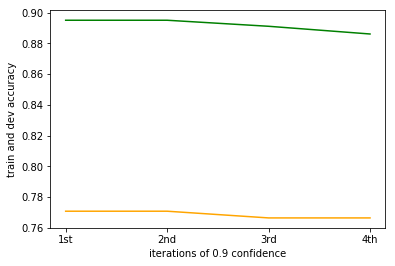

In [73]:
import matplotlib.pyplot as plt
xaxis = ['1st','2nd','3rd','4th']
traina=  [0.8950240069838499, 0.8950240069838499, 0.8910955914447839, 0.8860759493670886]
deva=    [0.7707423580786026, 0.7707423580786026, 0.7663755458515283, 0.7663755458515283]
plt.plot(xaxis, traina, color='g')
plt.plot(xaxis, deva, color='orange')
plt.xlabel('iterations of 0.9 confidence')
plt.ylabel('train and dev accuracy')